In [1]:
import torch
from torch import nn
from torch.autograd import Variable 
import pandas as pd
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import Trainer, TrainingArguments
from sklearn.metrics import precision_score,f1_score
import os
from datasets import load_dataset, DatasetDict, Dataset
# from torch.utils.data import Dataset, DataLoader #Data
from transformers import EarlyStoppingCallback, IntervalStrategy

import numpy as np
from tqdm import tqdm

from pathlib import Path
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    f1_score,
    balanced_accuracy_score,
)
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold

from utils import metrics, get_metrics, show_3_way


# use index0 to load bert-base

In [2]:
model_list = ['bert-base-uncased', 'bert-large-uncased', 'distilbert-base-uncased', 'xlnet-base-cased', 'roberta-base', 'roberta-large', 'albert-base-v2', 'microsoft/deberta-base']   
cmodel = model_list[0]
print(cmodel)

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("cpu")
print(device)

bert-base-uncased
cpu


In [3]:
cc_train = pd.read_csv('/home/linj26/llm/Bert_works/data/synthetic_compsent_masking.csv')
train_texts = cc_train['text']
train_labels = cc_train['label']
print(f'train_texts :{train_texts.shape}')

cc_test = pd.read_csv('/home/linj26/llm/Bert_works/data/dataset_compsent_masking.csv')
test_texts = cc_test['text']
test_labels = cc_test['label']
print(f'test_texts :{test_texts.shape}')

train_texts :(5000,)
test_texts :(7199,)


# tokenizer and segment embedding

In [4]:
def update_seg_embeddings(tokenizer, encodings):
    
    input_ids = encodings['input_ids']
    seg_embeddings = encodings['token_type_ids']
    
    new_tok_id = tokenizer.vocab_size + 1
    new_seg_embs = []
    
    for inp_ids, seg_emb in zip(input_ids, seg_embeddings):
        seg_embs = [0 if(x == new_tok_id or x == 0) else 1 for x in inp_ids]
        new_seg_embs.append(seg_embs)
        
    # new_seg_embs = torch.Tensor(new_seg_embs).long()
    encodings['token_type_ids'] = new_seg_embs
    
    return encodings

tokenizer = AutoTokenizer.from_pretrained(cmodel)
tokenizer.add_tokens(['<current_entity>', '<other_entity>'])

def tokenize_function(data):

    device = torch.device("cpu")

    # text = data['text']
    text = data

    encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt').to(device)

    print(f"encoded_input: {encoded_input['input_ids'].shape}")

    train_encodings = update_seg_embeddings(tokenizer, encoded_input)

    train_encodings['input_ids'] = np.array(train_encodings['input_ids'])
    train_encodings['token_type_ids'] = np.array(train_encodings['token_type_ids'])
    train_encodings['attention_mask'] = np.array(train_encodings['attention_mask'])

    print(f"train_encodings['input_ids']: {train_encodings['input_ids'].shape}")


    return train_encodings

# define custom bert

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cpu")

class BertClassifier(nn.Module):
    def __init__(self, n_classes, model, len_tokenizer):
        super(BertClassifier, self).__init__()
        #BERT
        self.config = AutoConfig.from_pretrained(model)        
        self.bert = AutoModel.from_pretrained(model, output_attentions=True)            
        self.bert.resize_token_embeddings(len_tokenizer)
        
        # args
        self.n_classes = n_classes

        # classifier
        self.out = nn.Linear(768, n_classes)
        self.drop = nn.Dropout(p=0.3)

    def forward(self, input_ids, attention_mask, token_type_ids, labels):
        self.bert = self.bert.to(device)
        self.out = self.out.to(device)
        input_ids, attention_mask, token_type_ids = input_ids.to(device), attention_mask.to(device), token_type_ids.to(device)
        labels = labels.to(device)

        # print(f'input_ids: {input_ids}')
        # print(f'attention_mask: {attention_mask}')
        # print(f'token_type_ids: {token_type_ids}')
        # print(f'test: {test}')

        # BERT
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids = token_type_ids)
        self.hidden_state, self.pooler_output, self.attention = bert_output[0], bert_output[1], bert_output[-1]
        pooler_output = self.pooler_output
        pooler_output = self.drop(pooler_output)

        # classifier: 1 FC layer
        preds = self.out(pooler_output)

        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(preds.view(-1, self.n_classes), labels.view(-1))
            return loss, preds, self.hidden_state, self.pooler_output, self.attention
        return preds, self.hidden_state, self.pooler_output, self.attention
    
    def convert_ids_to_tokens(self, input_ids):
        return tokenizer.convert_ids_to_tokens(input_ids)

# main function

keep random_state = 1 if you are doing college confidential so that we can get the same train/test split

In [6]:
os.environ["WANDB_DISABLED"] = "true"

K = 5
iter = 0
skf = StratifiedKFold(n_splits = K, shuffle = True, random_state = 1) 

results_train_metrics = []
results_val_metrics = []
results_test_metrics = []

for train_index, val_index in skf.split(train_texts, train_labels):

    ''' --------------- load data --------------- '''
    kfold_train_data = train_texts[train_index]
    kfold_train_labels = train_labels[train_index]
    
    kfold_val_data = train_texts[val_index]
    kfold_val_labels = train_labels[val_index]

#     ''' --------------- tokenize text --------------- '''
#     kfold_train_data = tokenize_function(kfold_train_data.tolist())
#     kfold_val_data = tokenize_function(kfold_val_data.tolist())
#     tokenized_test_texts = tokenize_function(test_texts.tolist())

#     ''' --------------- create dataset --------------- '''
#     dataset = DatasetDict({'train':Dataset.from_dict({'label':kfold_train_labels,
#                                                       'input_ids':kfold_train_data['input_ids'],
#                                                       'token_type_ids':kfold_train_data['token_type_ids'],
#                                                       'attention_mask':kfold_train_data['attention_mask']
#                                                       }),
#                                 'valid':Dataset.from_dict({'label':kfold_val_labels,
#                                                            'input_ids':kfold_val_data['input_ids'],
#                                                            'token_type_ids':kfold_val_data['token_type_ids'],
#                                                            'attention_mask':kfold_val_data['attention_mask']
#                                                            }),
#                                 'test':Dataset.from_dict({'label':test_labels,
#                                                            'input_ids':tokenized_test_texts['input_ids'],
#                                                            'token_type_ids':tokenized_test_texts['token_type_ids'],
#                                                            'attention_mask':tokenized_test_texts['attention_mask']
#                                                            }),                                                           
#                                                         })
#     tokenized_dataset = dataset
#     ''' --------------- define model --------------- '''
#     model = BertClassifier(4, cmodel, len(tokenizer))
#     # model = model.to(device)

#     ''' --------------- train model --------------- '''
#     training_args = TrainingArguments(
#         output_dir='./results',          # output directory
#         num_train_epochs=100,          # 100     # total number of training epochs
#         per_device_train_batch_size=64,  # batch size per device during training
#         per_device_eval_batch_size=64,   # batch size for evaluation
#         warmup_steps=5,                # number of warmup steps for learning rate scheduler
#         weight_decay=0.01,               # strength of weight decay
#         max_grad_norm=1,
#         # save_strategy="no",
#         # learning_rate=0.0006, #0.2
#         logging_strategy  = 'epoch',
#         evaluation_strategy = IntervalStrategy.STEPS,
#         eval_steps = 50,
#         load_best_model_at_end=True,
#         save_total_limit = 5, 
#         # metric_for_best_model = 'accuracy',
#     )

#     trainer = Trainer(
#         model=model,                         # the instantiated 🤗 Transformers model to be trained
#         args=training_args,                  # training arguments, defined above
#         train_dataset=tokenized_dataset["train"],         # training dataset
#         eval_dataset=tokenized_dataset["valid"],          # evaluation dataset
#         callbacks = [EarlyStoppingCallback(early_stopping_patience=10)],
#     )

#     trainer.train()

#     ''' --------------- save model --------------- '''
#     save_dir = f"../models/Bert_FT/iter_{iter}"
#     save_dir = Path(save_dir)
#     save_dir.mkdir(parents=True, exist_ok=True)

#     tokenizer.save_pretrained(save_dir)
#     trainer.save_model(save_dir)
#     torch.save(model.state_dict(), f'{save_dir}/pytorch_model.bin')
#     model.config.to_json_file(f'{save_dir}/config.json')

#     print(f'------------ train results ------------')
#     train_preds = trainer.predict(tokenized_dataset["train"])
#     train_preds = train_preds.predictions[0].argmax(1)
#     train_label = tokenized_dataset["train"]['label']
#     train_metrics = show_3_way(np.array(train_label), np.array(train_preds))

#     print(f'------------ val results ------------')
#     val_preds = trainer.predict(tokenized_dataset["valid"])
#     val_preds = val_preds.predictions[0].argmax(1)
#     val_label = tokenized_dataset["valid"]['label']
#     val_metrics = show_3_way(np.array(val_label), np.array(val_preds))

#     results_train_metrics.append(train_metrics)
#     results_val_metrics.append(val_metrics)

#     print(f'------------ test results ------------')
#     test_preds = trainer.predict(tokenized_dataset["test"])
#     test_preds = test_preds.predictions[0].argmax(1)
#     test_label = tokenized_dataset["test"]['label']
#     test_metrics = show_3_way(np.array(test_label), np.array(test_preds))

#     results_test_metrics.append(test_metrics)
#     # break
#     iter += 1



In [7]:
# save_dir = f"../models/Bert_FT/iter_{iter}"
# save_dir = Path(save_dir)
# save_dir.mkdir(parents=True, exist_ok=True)

# tokenizer.save_pretrained(save_dir)
# trainer.save_model(save_dir)
# torch.save(model.state_dict(), f'{save_dir}/pytorch_model.bin')
# model.config.to_json_file(f'{save_dir}/config.json')


# load trained model

In [8]:
# save_dir = f"../models/Bert_FT/iter_4"
# save_dir = f"iter_4"
save_dir = f"/home/linj26/llm/Bert_works/models/Bert_FT/iter_4"

test_model2 = BertClassifier(4, cmodel, len(tokenizer))

test_model2.load_state_dict(torch.load(f'{save_dir}/pytorch_model.bin'))
test_model2.eval()

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 30524. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30524, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

# pick up short sentence

In [9]:
kfold_train_data = train_texts[train_index]
kfold_train_labels = train_labels[train_index]
print(f'kfold_train_data: {kfold_train_data.shape}')
print(f'kfold_train_labels: {kfold_train_labels.shape}')

train_kflod = pd.DataFrame()
train_kflod['text'] = kfold_train_data
train_kflod['label'] = kfold_train_labels

print(f'train_kflod: {train_kflod.shape}')

kfold_train_data: (4000,)
kfold_train_labels: (4000,)
train_kflod: (4000, 2)


In [10]:
text_03_set= []
label_03_set = []

text_1_set= []
label_1_set = []

text_2_set= []
label_2_set = []

for i in range(len(train_kflod)):
    data = train_kflod.iloc[i, :]
    text = data['text']
    label = data['label']

    len_text = len(text.split())

    if (label == 0) and 10 < len_text and len_text < 20 and len(label_03_set) < 10:
        label_03_set.append(label)
        text_03_set.append(text)

    elif (label == 1) and 10 < len_text and len_text < 20 and len(label_1_set) < 10:
        label_1_set.append(label)
        text_1_set.append(text)

    elif (label == 2) and 10 < len_text and len_text < 20 and len(label_2_set) < 10:
        label_2_set.append(label)
        text_2_set.append(text)

print(f'label_03_set: {len(label_03_set)}')
print(f'label_1_set: {len(label_1_set)}')
print(f'label_2_set: {len(label_2_set)}')

labels = label_03_set + label_1_set + label_2_set
texts = text_03_set + text_1_set + text_2_set

# print(len(labels))
# print(len(texts))

short_trainset = pd.DataFrame()
short_trainset['text'] = texts
short_trainset['label'] = labels

print(f'short_trainset: {short_trainset.shape}')


label_03_set: 10
label_1_set: 10
label_2_set: 10
short_trainset: (30, 2)


# tokenize short sentence

In [11]:
short_texts = short_trainset['text']
short_labels = short_trainset['label']
print(f'short_texts :{short_texts.shape}')

''' --------------- tokenize text --------------- '''
kfold_short_data = tokenize_function(short_texts.tolist())

short_texts :(30,)
encoded_input: torch.Size([30, 25])
train_encodings['input_ids']: (30, 25)


In [12]:
input_ids = kfold_short_data['input_ids']
token_type_ids = kfold_short_data['token_type_ids']
attention_mask = kfold_short_data['attention_mask']
label = short_labels

input_ids = torch.Tensor(input_ids).long()
token_type_ids = torch.Tensor(token_type_ids).long()
attention_mask = torch.Tensor(attention_mask).long()
label = torch.Tensor(label).long()

print(f'input_ids: {input_ids.shape}')
print(f'token_type_ids: {token_type_ids.shape}')
print(f'attention_mask: {attention_mask.shape}')
print(f'label: {label.shape}')

input_ids: torch.Size([30, 25])
token_type_ids: torch.Size([30, 25])
attention_mask: torch.Size([30, 25])
label: torch.Size([30])


# input data into trained model

In [13]:
loss, preds, hidden_state, pooler_output, attention = test_model2(input_ids, attention_mask, token_type_ids, label)

print(f'loss: {loss.shape}')
print(f'preds: {preds.shape}')
print(f'hidden_state: {hidden_state.shape}')
print(f'pooler_output: {pooler_output.shape}')
print(f'attention: {attention[0].shape}')


loss: torch.Size([])
preds: torch.Size([30, 4])
hidden_state: torch.Size([30, 25, 768])
pooler_output: torch.Size([30, 768])
attention: torch.Size([30, 12, 25, 25])


In [14]:
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
# inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt')
# input_ids = inputs['input_ids']
# token_type_ids = inputs['token_type_ids']

attention_weights: (25, 25)


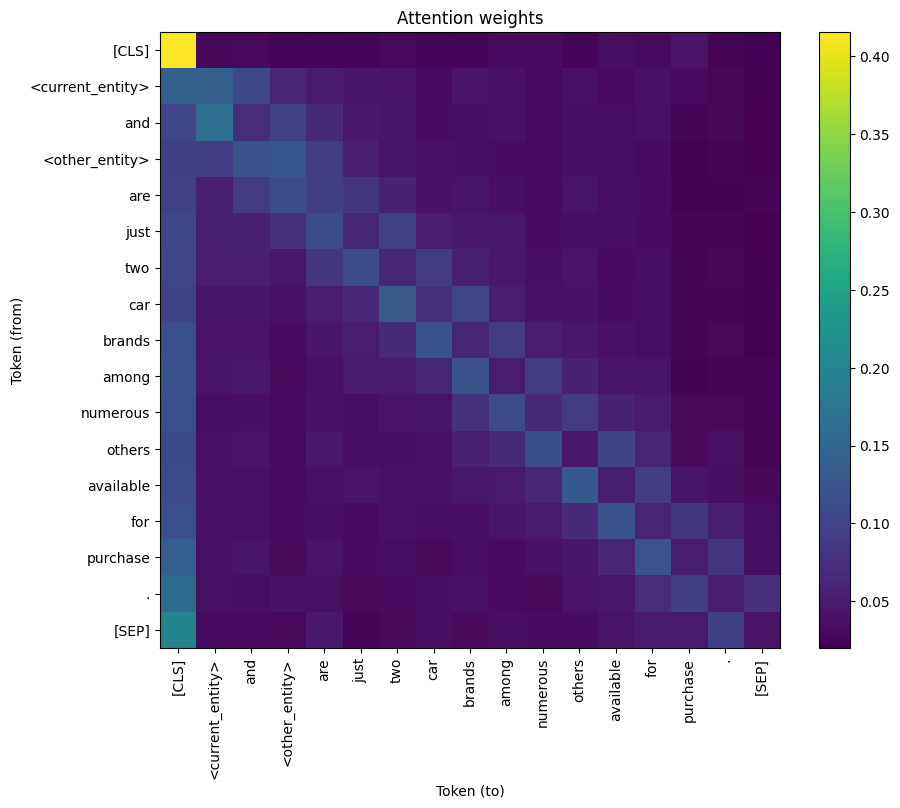

attention_weights: (30, 25, 25)


In [15]:
import matplotlib.pyplot as plt

attention_weights = attention[0].mean(0).mean(0)
attention_weights = attention_weights.cpu().data.numpy()
print(f'attention_weights: {attention_weights.shape}')
tokens = tokenizer.convert_ids_to_tokens(input_ids[0].tolist())

# remove last 8 columns and rows from attention_weights
attention_weights = attention_weights[:-8, :-8]
tokens = tokens[:-8]

plt.figure(figsize=(10,8))
plt.imshow(attention_weights, cmap='viridis', aspect='auto')
plt.yticks(range(len(tokens)), tokens)
plt.xticks(range(len(tokens)), tokens, rotation=90)
plt.colorbar()

plt.title('Attention weights')
plt.xlabel('Token (to)')
plt.ylabel('Token (from)')

plt.show()

# new attention is the mean of all attention heads but do it for all sentences in the batch
attention_weights = attention[0].mean(1)
attention_weights = attention_weights.cpu().data.numpy()
print(f'attention_weights: {attention_weights.shape}')

In [16]:
average_attention = tuple(torch.mean(x, dim=1, keepdim=True) for x in attention)
print(f"attention shape: {attention[0].shape}")
print(f"average_attention shape: {average_attention[0].shape}")

attention shape: torch.Size([30, 12, 25, 25])
average_attention shape: torch.Size([30, 1, 25, 25])


In [17]:
from bertviz import head_view, model_view

for i in range(len(kfold_short_data['input_ids'])):
    input_ids = kfold_short_data['input_ids'][i:i+1]
    token_type_ids = kfold_short_data['token_type_ids'][i:i+1]
    attention_mask = kfold_short_data['attention_mask'][i:i+1]
    label = np.array([short_labels[i]])

    print(f"input_ids: {input_ids.shape}")
    print(f"attention_mask: {attention_mask.shape}")
    print(f"token_type_ids: {token_type_ids.shape}")
    print(f"label: {label.shape}")

    input_ids = torch.Tensor(input_ids).long()
    token_type_ids = torch.Tensor(token_type_ids).long()
    attention_mask = torch.Tensor(attention_mask).long()
    label = torch.Tensor(label).long()

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].tolist())

    loss, preds, hidden_state, pooler_output, attention = test_model2(input_ids, attention_mask, token_type_ids, label)

    head_view(attention, tokens)
    model_view(attention, tokens)
    break

input_ids: (1, 25)
attention_mask: (1, 25)
token_type_ids: (1, 25)
label: (1,)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>